[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/02_small_worlds_and_large_worlds.ipynb)

# 2. Small Worlds and Large Worlds

In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  !pip install watermark
except:
  pass

In [2]:
%load_ext watermark

In [3]:
# Core
import numpy as np
import arviz as az
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.stats as stats

# visualization 
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions

In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas

numpy                 : 1.21.5
tensorflow            : 2.7.0
tensorflow_probability: 0.15.0
arviz                 : 0.11.4
scipy                 : 1.7.3
pandas                : 1.3.5



In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'

## 2.1 The garden of forking data

### 2.1.3 From counts to probability

Suppose we have a bag of four marbles, each of which can be either blue or white. There are five possible compositions of the bag, ranging from all white marbles to all blue marbles. Now, suppose we make three draws with replacement from the bag, and end up with blue, then white, then blue. If we were to count the ways that each bag composition could produce this combination of samples, we would find the vector in ways below. For example, there are zero ways that four white marbles could lead to this sample, three ways that a bag composition of one blue marble and three white marbles could lead to the sample, as so on.

We can convert these counts to probabilities by simply dividing the counts by the sum of all the counts.


##### Code 2.1

In [6]:
ways = tf.constant([0., 3, 8, 9, 0])
new_ways = ways / tf.reduce_sum(ways)

new_ways

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([0.  , 0.15, 0.4 , 0.45, 0.  ], dtype=float32)>

#### 2.3.2.1 Observed variables

Consider a globe of the earth that we toss into the air nine times. We want to compute the probability that our right index finger will land on water six times out of nine. We can use the binomial distribution to compute this, using a probability of 0.5 of landing on water on each toss.

## 2.3 Components of the model

##### Code 2.2

In [7]:
tf.exp(tfd.Binomial(total_count=9, probs=0.5).log_prob(6))

<tf.Tensor: shape=(), dtype=float32, numpy=0.16406254>

## 2.4 Making the model go

### 2.4.3 Grid Approximation

Create a grid approximation for the globe tossing model, for the scenario described in the section above. In the grid approximation technique, we approximate a continuous posterior distribution by using a discrete grid of parameter values.

##### Code 2.3

In [8]:
# define grid
n_points = 20 # change to an odd number for Code 2.5 graphs to 
              # match book examples in Figure 2.6
p_grid = tf.linspace(start=0., stop=1., num=n_points)

#define prior
prior = tf.ones([n_points])

# compute likelihood at each value in grid
likelihood = tfd.Binomial(total_count=9, probs=p_grid).prob(6)

# compute product of likelihood and prior
unstd_posterior = likelihood * prior

# standardize the posterior, so it sums to 1
posterior = unstd_posterior / tf.reduce_sum(unstd_posterior)

posterior

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0.00000000e+00, 7.98984274e-07, 4.30771906e-05, 4.09079541e-04,
       1.89388765e-03, 5.87387430e-03, 1.40429335e-02, 2.78517436e-02,
       4.78011407e-02, 7.28073791e-02, 9.98729542e-02, 1.24264322e-01,
       1.40314341e-01, 1.42834887e-01, 1.28943324e-01, 9.98729020e-02,
       6.20589107e-02, 2.64547635e-02, 4.65966761e-03, 0.00000000e+00],
      dtype=float32)>

##### Code 2.4

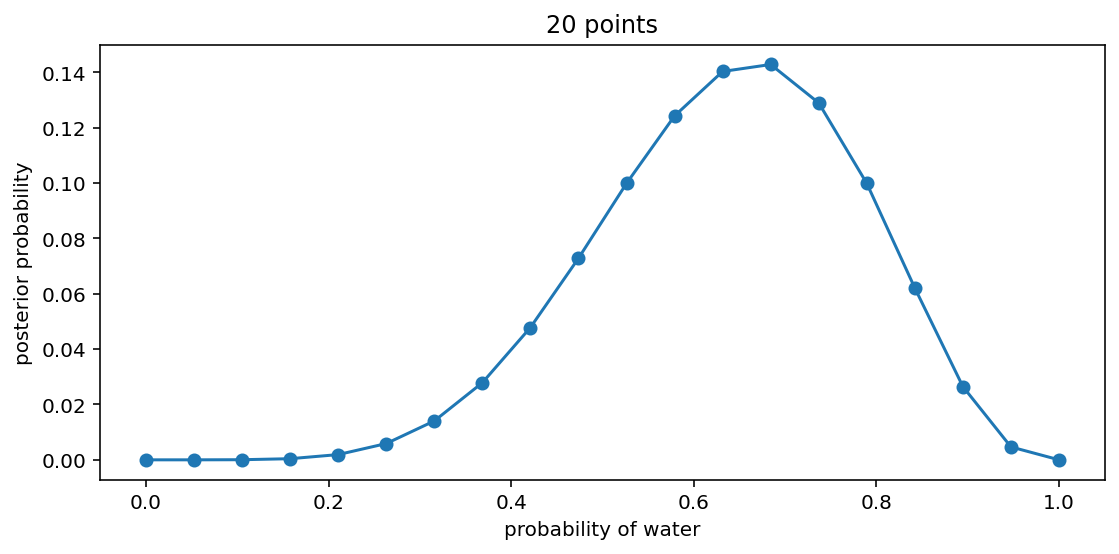

In [9]:
_, ax = plt.subplots(figsize=(9, 4))
ax.plot(p_grid, posterior, "-o")
ax.set(
    xlabel="probability of water",
    ylabel="posterior probability",
    title="20 points");

##### Code 2.5

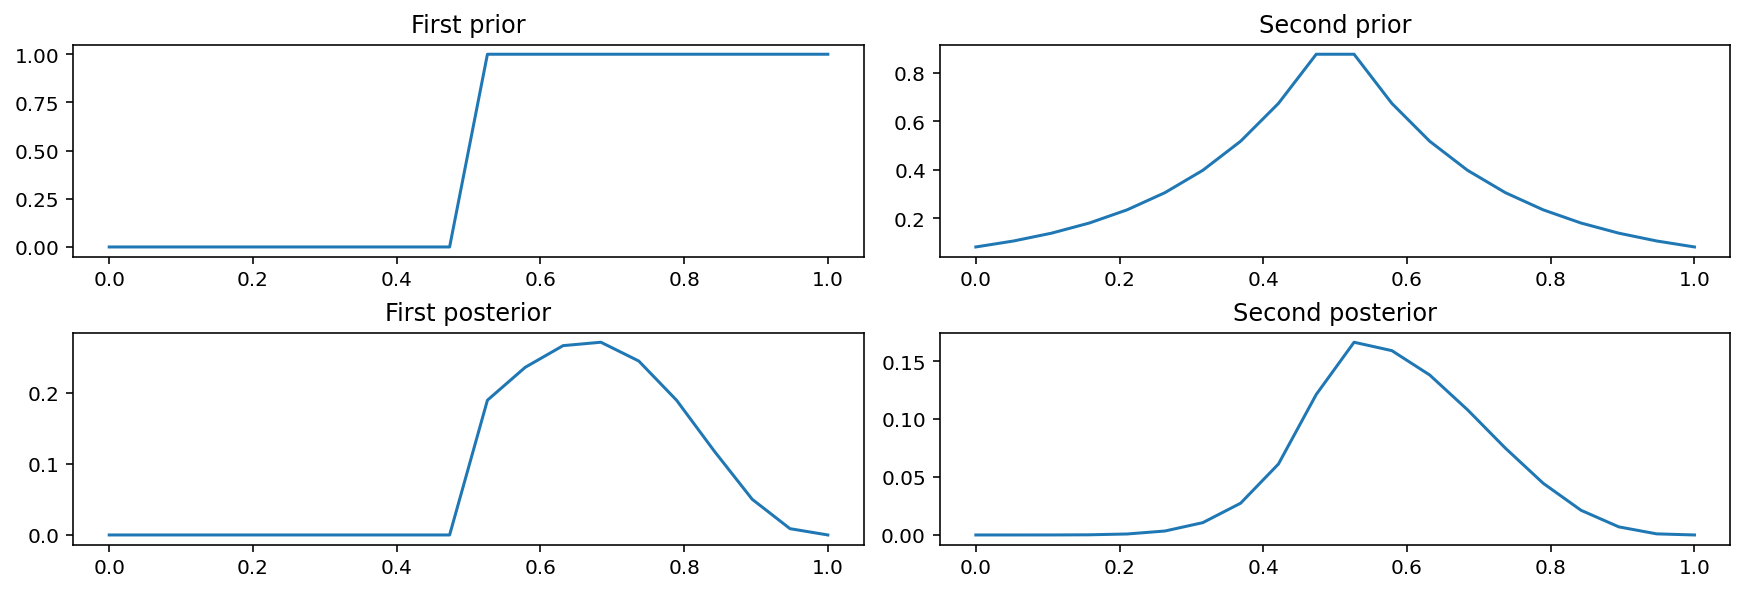

In [10]:
first_prior = tf.where(condition=p_grid < 0.5, x=0., y=1)
second_prior = tf.exp(-5 * abs(p_grid - 0.5))

_, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 4), 
                       constrained_layout=True)

axes[0, 0].plot(p_grid, first_prior)
axes[0, 0].set_title('First prior')
axes[1, 0].plot(p_grid, first_prior * likelihood)
axes[1, 0].set_title('First posterior')

axes[0, 1].plot(p_grid, second_prior)
axes[0, 1].set_title('Second prior')
axes[1, 1].plot(p_grid, second_prior * likelihood)
axes[1, 1].set_title('Second posterior');

### 2.4.4 Quadratic Approximation

##### Code 2.6

TFP doesn't natively provide a quap function, like in the book. But it has a lot of optimization tools. We'll use bfgs, which gives us a somewhat straightforward way to get both the measurement and the standard error.

In [11]:
W = 6
L = 3
dist = tfd.JointDistributionNamed({
    "water": lambda probability: tfd.Binomial(total_count=W + L, 
                                              probs=probability),
    "probability": tfd.Uniform(low=0., high=1.)
})

def neg_log_prob(x):
    return tfp.math.value_and_gradient(
          lambda p: -dist.log_prob(
              water=W, 
              probability=tf.clip_by_value(p[-1], 0., 1.)), 
          x,
    )

results = tfp.optimizer.bfgs_minimize(neg_log_prob, initial_position=[0.5])
assert results.converged

The results object itself has a lot of information about the optimization process. The estimate is called the position, and we get the standard error from the inverse_hessian_estimate.

In [12]:
approximate_posterior = tfd.Normal(
    results.position,
    tf.sqrt(results.inverse_hessian_estimate),
)

print(
    "mean:", approximate_posterior.mean(),
    "\nstandard deviation: ", approximate_posterior.stddev(),
)

mean: tf.Tensor([[0.6666667]], shape=(1, 1), dtype=float32) 
standard deviation:  tf.Tensor([[0.15718359]], shape=(1, 1), dtype=float32)


Let's compare the mean and standard deviation from the quadratic approximation with an analytical approach based on the Beta distribution.

##### Code 2.7

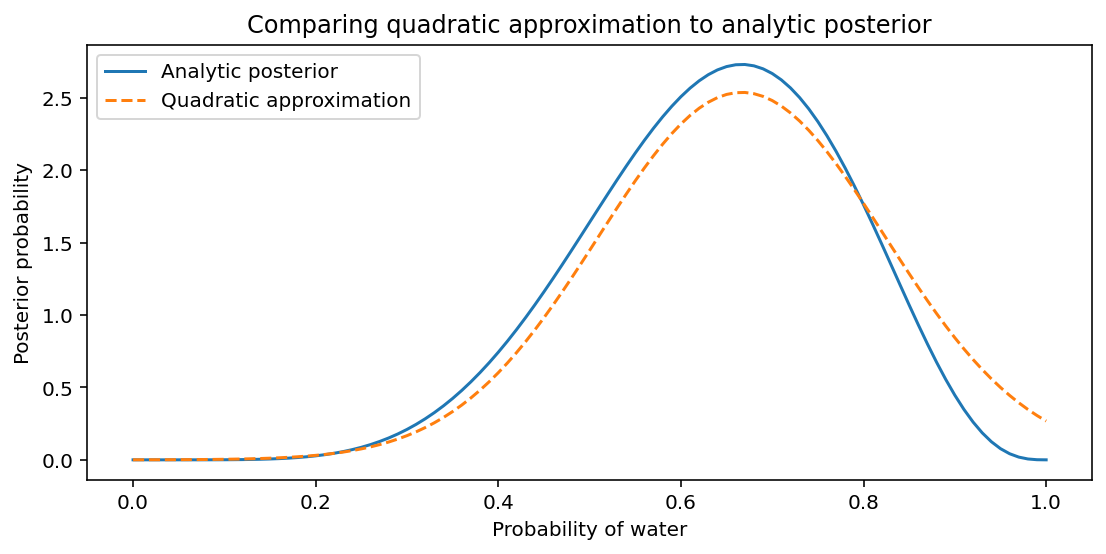

In [13]:
_, ax = plt.subplots(figsize=(9, 4))

x = tf.linspace(0., 1., num=101)
ax.plot(x, tfd.Beta(W + 1, L + 1).prob(x), label='Analytic posterior')
# values obained from quadratic approximation
ax.plot(x, tf.squeeze(approximate_posterior.prob(x)), "--", 
         label='Quadratic approximation')

ax.set(
    xlabel='Probability of water',
    ylabel='Posterior probability',
    title='Comparing quadratic approximation to analytic posterior'
)
ax.legend();

### 2.4.5. Markov chain Monte Carlo

We can estimate the posterior using a Markov chain Monte Carlo (MCMC) technique, which will be explained further in Chapter 9. An outline of the algorithm follows. It is written primarily in numpy to illustrate the steps you would take.

##### Code 2.8

In [14]:
n_samples = 1000
p = np.zeros(n_samples)
p[0] = 0.5
W = 6
L = 3
for i in range(1, n_samples):
    p_new = tfd.Normal(loc=p[i - 1], scale=0.1).sample(1)
    if p_new < 0:
        p_new = -p_new
    if p_new > 1:
        p_new = 2 - p_new
    q0 = tf.exp(tfd.Binomial(total_count=W+L, probs=p[i-1]).log_prob(W))
    q1 = tf.exp(tfd.Binomial(total_count=W+L, probs=p_new).log_prob(W))
    if stats.uniform.rvs(0, 1) < q1 / q0:
        p[i] = p_new
    else:
        p[i] = p[i - 1]

In [15]:
# using built-in functions for mcmc

@tf.function
def do_sampling():
  def get_model_log_prob(probs):
    return tfd.Binomial(total_count=W + L, probs=probs).log_prob(W)

  sampling_kernel = tfp.mcmc.RandomWalkMetropolis(get_model_log_prob)

  return tfp.mcmc.sample_chain(
      num_results=5000,
      current_state=.5,
      kernel=sampling_kernel,
      num_burnin_steps=500,
    trace_fn=None, 
  )

samples = do_sampling()

##### Code 2.9

With the samples from the posterior distribution in p, we can compare the results of the MCMC approximation to the analytical posterior.

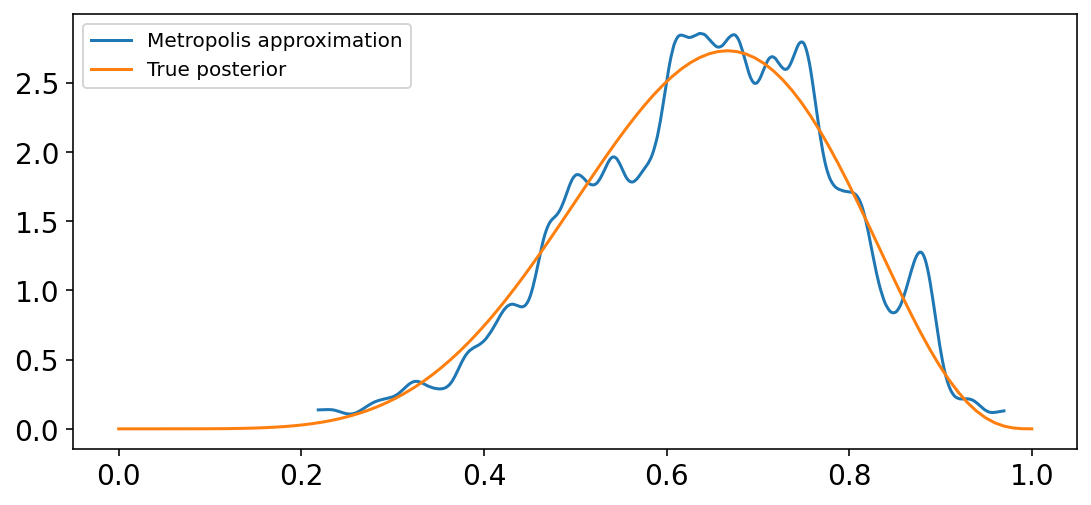

In [16]:
_, ax = plt.subplots(figsize=(9, 4))

az.plot_kde(samples.numpy(), label="Metropolis approximation", ax=ax)
x = tf.linspace(0., 1., num=100)
ax.plot(x, tfd.Beta(W + 1, L + 1).prob(x), "C1", label="True posterior")
ax.legend();